> ### EEE4423: Deep Learning Lab

# LAB \#10: Image Style Transfer

<h4><div style="text-align: right"> Due date: May 13, 2022  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab10.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[2017142136] [이관희]</span> </h2>

In [3]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-06 13:42:13.814628




# Neural Stylization with Pytorch
## Introduction


<img src="http://drive.google.com/uc?export=view&id=1crqAv5aoJ3uMSDFT99l6VuzY3VUlF_C7" alt="no_image" style="width: 900px;"/>

This lab introduces a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm takes two images, a content-image, and a style-image, and generates the optimized image to resemble the content of the content-image and the artistic style of the style-image.


**Main idea**

To transfer the style image $\textit{I}_s$ onto a content image $\textit{I}_c$ we synthesize a new image that simultaneously matches the content representation of $\textit{I}_c$ and the style representation of $\textit{I}_s$ (Fig). Thus we jointly minimize the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network.
<img src="http://drive.google.com/uc?export=view&id=1BhfqqQEMn3AyHpc6fB-shQDlU-tQeoLz" alt="no_image" style="width: 900px;"/>

In [4]:
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

**Style and content image**

In [5]:
style_img_name = '../dataset/lab10/style/mosaic.jpg'
content_img_name = '../dataset/lab10/content/Tuebingen_Neckarfront.jpg'

In [6]:
style_img = Image.open(style_img_name)
content_img = Image.open(content_img_name)

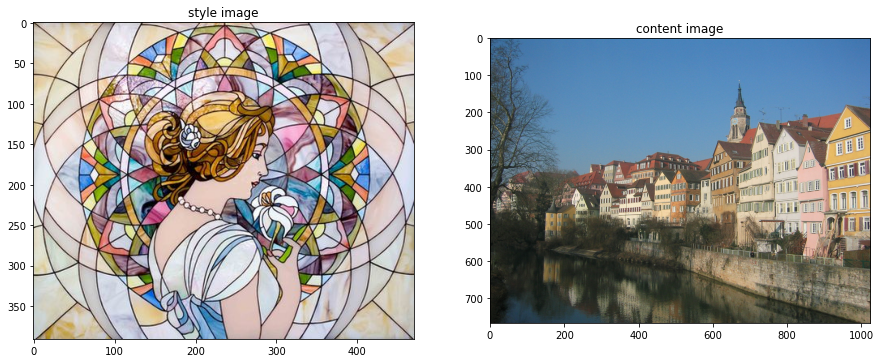

In [7]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Style representation

To obtain a representation of the style of an input image, we use a feature space designed to capture texture information. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $\mathit{G} \in \mathcal{R}^{\mathit{N_l}  \times  \mathit{N_l}}$, where $\mathit{G^l_{ij}}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

### <center> ${\mathit{G^l_{ij}} = \sum_{k}{F^l_{ik}F^l_{jk}}}$ </center>

In [8]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2) #features_t -> (b,w*h,ch)
    gram = features.bmm(features_t) / (ch * h * w)
    # bmm : Performs a batch matrix-matrix product of matrices stored in input and mat2
    # (ch * h * w)으로 나누어지는 것은 너무 커지지않게 normalize해주는 것이다.
    return gram

### Deep image representations

In this work we show how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the content and the style of natural images.

The image reperesentations were generated on the basis of the VGG network, which was trained to perform object recognition and localization. We use the feature space provided by the 16 convolutional and 5 pooling layers of the 19-layer VGG network.

In [9]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg = vgg.vgg19(pretrained=False)


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg.features._modules.items():
            x = module(x)
            if name in layer_name:
                output[layer_name[name]] = x
        return output

In [10]:
loss_net = LossNetwork().cuda()
checkpoint = torch.load('./pretrain/lab10/vgg19.pth')
loss_net.vgg.load_state_dict(checkpoint)
for param in loss_net.parameters():
    param.requires_grad = False

Content representation is on layer ‘conv4 2’ and the style representation is on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’

In [11]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

In [12]:
# # 추가한 코드
# import torchvision.models.vgg as vgg

# vgg = vgg.vgg19(pretrained=False)
# output = {}
# for name, module in vgg.features._modules.items():
#     print(name , ' ' , module)
#     if name in content_layer_name:
#         output[content_layer_name[name]] = name

In [13]:
# output

**Pre and post processing for images**

In [14]:
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

In [15]:
content = prep(content_img).cuda().unsqueeze(0)
style = prep(style_img).cuda().unsqueeze(0)

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img]) #out_img을 업데이트하기 때문에 이렇게 설계한다.
n_iter = [0]

In [16]:
# a= [ k for k in range(5)]
# print(a)

In [17]:
# loss_net(style, style_layer_name)

In [18]:
# loss_net(style, style_layer_name).values()

In [19]:
# len([gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()])

In [20]:
# content_gt[0]

**Hyper parameters**

In [21]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [22]:
while n_iter[0] <= max_iter:
    
    # optimize할 떄 한번하고 끝이 아니다. 찾아봐라
    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):  #show_iter = 50
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

Iteration: 50, loss: 9.065893
Iteration: 100, loss: 6.381294
Iteration: 150, loss: 5.698671
Iteration: 200, loss: 5.358714
Iteration: 250, loss: 5.155450
Iteration: 300, loss: 5.030104
Iteration: 350, loss: 4.941926
Iteration: 400, loss: 4.876918
Iteration: 450, loss: 4.826862
Iteration: 500, loss: 4.786831


**Visualize result images**

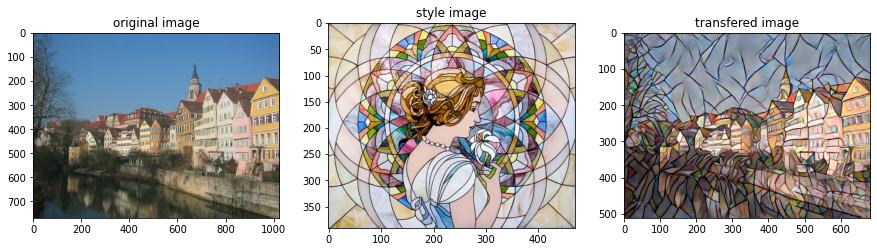

In [23]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()

In [24]:
out_img.size()

torch.Size([1, 3, 512, 682])



# Perceptual Losses for Style Transfer with Pytorch


**Main idea**

Previous method produces high-quality results, but is computationally expensive since each step of the optimization problem requires a forward and backward pass through the pretrained network. To overcome this computational burden, we train a feed-forward network to quickly approximate solutions to their optimization problem.
<img src="http://drive.google.com/uc?export=view&id=1GFM9l-63SsOFYHP-g2WNN2T6zNDdD09Z" alt="no_image" style="width: 900px;"/>

$\mathcal{L}_{total} = \alpha\sum_{}{\mathcal{l}_{content}} + \beta\sum_{}{\mathcal{l}_{style}} + \gamma\mathcal{l}_{TV}$

- $\mathcal{l}_{content}^{\phi,j} = ||\phi_j(\hat{y}) - \phi_j(y)||^2_2$, $\phi$ represents vgg feature

- $\mathcal{l}_{style}^{\phi,j} = ||G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)||^2_F$, $G$ represents gram matrix.

- $\mathcal{l}_{TV}(y) = \sum_{i,j}{|y_{i+1,j}-y_{i,j}|+|y_{i,j+1}-y_{i,j}|}$



**Data loader**

In [25]:
data_root = '../dataset/lab10/train'
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 1.1 Write code (Image Transform Net) [3 points]

<img src="http://drive.google.com/uc?export=view&id=1OQzOwfRgpncvvBCwUCJbShYQGBElUqjW" alt="no_image" style="width: 400px;"/>

##### Residual block (channel, x)
- Conv 1: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv 2: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Residual Connection

#### ImageTransformNet
- Conv $9\times9$  (in: 3, out: 32, padding: 4) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 32, out: 64, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 64, out:128, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- 5 Residual block(channel: 128)
- $2\times$ Nearest Upsample
- Conv $3\times3$  (in: 128, out:64, padding: 1) with reflection padding
- Instance Norm
- Relu
- **$2\times$ Nearest Upsample**
- Conv $3\times3$  (in: 64, out:32, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv $9\times9$  (in: 32, out:3, padding: 4) with reflection padding



In [26]:
# relfection padding위해 설계한 class padding 후 conv layer 톰과이다. 따라서 공통적인 특징을 가능 ConvLayer을 설계할 것이다.
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        padding = kernel_size // 2 # 계산하면 맞다.
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride) # padding = 0 -> 이미 위에서 padding을 고려해주었기 때문에 

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out 

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=upsample, mode='nearest')
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out    
    
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        # nonlineraity
        self.relu = nn.ReLU()

        # encoding layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1_encoding = nn.InstanceNorm2d(32, affine=True)

        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2_encoding = nn.InstanceNorm2d(64, affine=True)

        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3_encoding = nn.InstanceNorm2d(128, affine=True)
        
        # residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        # decoding layers
        self.deconv3 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2 )
        self.in3_decoding = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2 )
        self.in2_decoding = nn.InstanceNorm2d(32, affine=True)

        self.deconv1 = ConvLayer(32, 3, kernel_size=9, stride=1)

    def forward(self, X):
        # encode
        y = self.relu(self.in1_encoding(self.conv1(X)))
        y = self.relu(self.in2_encoding(self.conv2(y)))
        y = self.relu(self.in3_encoding(self.conv3(y)))

        # residual layers
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)

        # decode
        y = self.relu(self.in3_decoding(self.deconv3(y)))
        y = self.relu(self.in2_decoding(self.deconv2(y)))
        y = self.deconv1(y)
        
        return y
        

In [27]:
transformer = ImageTransformNet().cuda()

In [28]:
try:
    from torchsummary import summary
except ModuleNotFoundError:
    !pip install torchsummary
    from torchsummary import summary
    pass

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("AlexNet's Summary:")
transformer.to(device)
summary(transformer, (3, 224, 224))

AlexNet's Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 232, 232]               0
            Conv2d-2         [-1, 32, 224, 224]           7,808
         ConvLayer-3         [-1, 32, 224, 224]               0
    InstanceNorm2d-4         [-1, 32, 224, 224]              64
              ReLU-5         [-1, 32, 224, 224]               0
   ReflectionPad2d-6         [-1, 32, 226, 226]               0
            Conv2d-7         [-1, 64, 112, 112]          18,496
         ConvLayer-8         [-1, 64, 112, 112]               0
    InstanceNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
  ReflectionPad2d-11         [-1, 64, 114, 114]               0
           Conv2d-12          [-1, 128, 56, 56]          73,856
        ConvLayer-13          [-1, 128, 56, 56]               0
   InstanceNorm2d-14

### 1.2 Find style and content representation layers in loss net [1 points]

In [29]:
style_layer_name = {
   #############
    # CODE HERE #
    #############
    '3': "relu1-2",
    '8': "relu2-2",
    '15': "relu3-3",
    '24': "relu4-3"
}

content_layer_name = {
    #############
    # CODE HERE #
    #############
#    '15': "relu3-3" # 2_2가 그림이 더 이쁘다.
     '8': "relu2-2"
}

In [30]:
# import torchvision.models.vgg as vgg

# net = vgg.vgg19(pretrained=False)

# net.features

In [31]:
style = transform(style_img).cuda().unsqueeze(0)
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
# 위의 값은 style을 뽑고 싶은 데이터의 style 정보 값이다. 

**Hyper parameters**

In [32]:
# You may adjust hyper paramters 
alpha = 1e0
beta = 1e4
gamma = 1e-5

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR) 
# ImageTransformNet만 업데이트 시키고 VGG는 freeze 시켜둠.

### 1.3 Train the image transformNet [4 points]

- Print total loss, content loss, style loss and total variation loss for every 50 iterations
- Style loss should contain all of the layers listed above
- Use alpha, beta, gamma as coefficient

In [33]:
transformer.train() # 이미 GPU에 올라가있다.
n_iter = 0
total_running_loss = 0.0
style_running_loss = 0.0
content_running_loss = 0.0
tv_running_loss = 0.0

class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            #############
            # CODE HERE #
            #############
            optimizer.zero_grad() # 학습 준비과정
            
            x= x.to(device) # input GPU에 올리기
            
            y_hat = transformer(x)
            
            ### style_running_loss
            style_layers = [gram_matrix(f) for f in loss_net(y_hat, style_layer_name).values()]
            # 위의 값은 input 이미지의 style 정보 값이다. 
            style_running_loss = 0
            for i in range(len(style_layers)):    
                style_running_loss += criterion(style_layers[i], style_gt[i])
                
            ### content_running_loss
            content_layers = [f for f in loss_net(y_hat, content_layer_name).values()]
            content_gt = [f.detach() for f in loss_net(x, content_layer_name).values()]
            
            content_running_loss = criterion(content_layers[0], content_gt[0])
            
            ### total variation regularization
            diff_i = torch.sum(torch.abs(y_hat[:, :, :, 1:] - y_hat[:, :, :, :-1]))
            diff_j = torch.sum(torch.abs(y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]))
            tv_running_loss = (diff_i + diff_j)

            loss = alpha * content_running_loss + beta * style_running_loss + gamma*tv_running_loss
#             loss = alpha * content_running_loss + beta * style_running_loss
            #print(loss)

            loss.backward()
        # 질문 detach() 질문 Trying to backward through the graph a second time -> 누적되서 생긴 오류 다시 iter 돌때 초기화가 필요하다.
            optimizer.step()            
            # print loss
            if n_iter%show_iter == (show_iter-1):  #show_iter = 50 0부터 시작하니 49 99 이렇게 출력해야 함.
                print('Iteration: %d, total loss: %.2f, content loss: %.2f, style loss : %.2f, tv loss: %.2f'%(n_iter+1, loss.item(),  alpha * content_running_loss,  beta * style_running_loss, gamma * tv_running_loss))
#                 print('Iteration: %d, total loss: %.2f, content loss: %.2f, style loss : %.2f'%(n_iter, loss.item(), content_running_loss, style_running_loss))
                # Iteration: 50, total loss: 35.99, content loss: 10.56, style loss: 23.45 tv loss: 1.98
            #질문 : 그 순간의 값을 출력해도 되는지 아님 평균한 값을 출력해야 되는지 
            if n_iter >= steps:
                raise Found
            n_iter+=1

except Found:
    pass
    

Iteration: 50, total loss: 25.92, content loss: 11.00, style loss : 12.42, tv loss: 2.50
Iteration: 100, total loss: 22.03, content loss: 11.81, style loss : 7.56, tv loss: 2.67
Iteration: 150, total loss: 20.18, content loss: 11.24, style loss : 6.12, tv loss: 2.82
Iteration: 200, total loss: 19.04, content loss: 11.28, style loss : 4.92, tv loss: 2.85
Iteration: 250, total loss: 17.56, content loss: 9.87, style loss : 5.02, tv loss: 2.67
Iteration: 300, total loss: 15.99, content loss: 9.43, style loss : 3.86, tv loss: 2.70
Iteration: 350, total loss: 16.70, content loss: 9.50, style loss : 4.40, tv loss: 2.81
Iteration: 400, total loss: 16.22, content loss: 8.99, style loss : 4.72, tv loss: 2.51
Iteration: 450, total loss: 15.65, content loss: 9.38, style loss : 3.46, tv loss: 2.81
Iteration: 500, total loss: 15.15, content loss: 8.78, style loss : 3.66, tv loss: 2.71
Iteration: 550, total loss: 15.20, content loss: 7.95, style loss : 4.84, tv loss: 2.41
Iteration: 600, total loss: 

In [34]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# transformer.to(device)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# i=0
# for x, _ in train_loader :
#     i+=1
#     if i==1 :
#         print(x.size())
#         x=x.cuda()
#         print(x.type())
#         print(device)
#         break

In [35]:
# transformer.to(device)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# i=0
# for x, _ in train_loader :
#     i+=1
#     if i==1 :
#         print(x.size())
#         x=x.cuda()
#         print(x.type())
#         print(device)
#         break

In [36]:
# from torch.autograd import Variable
# dtype = torch.cuda.FloatTensor
# x = Variable(x).type(dtype)
# x.type()


### 1.4 Discuss the result [2 points]
- Compare the result of neural style with yours
- Adjust the hyper parameter and analyze each result
- Use transform function before and after inference

torch.Size([1, 3, 768, 1024])
torch.float32
<built-in method type of Tensor object at 0x7f7ae2649dc0>


(-0.5, 1023.5, 767.5, -0.5)

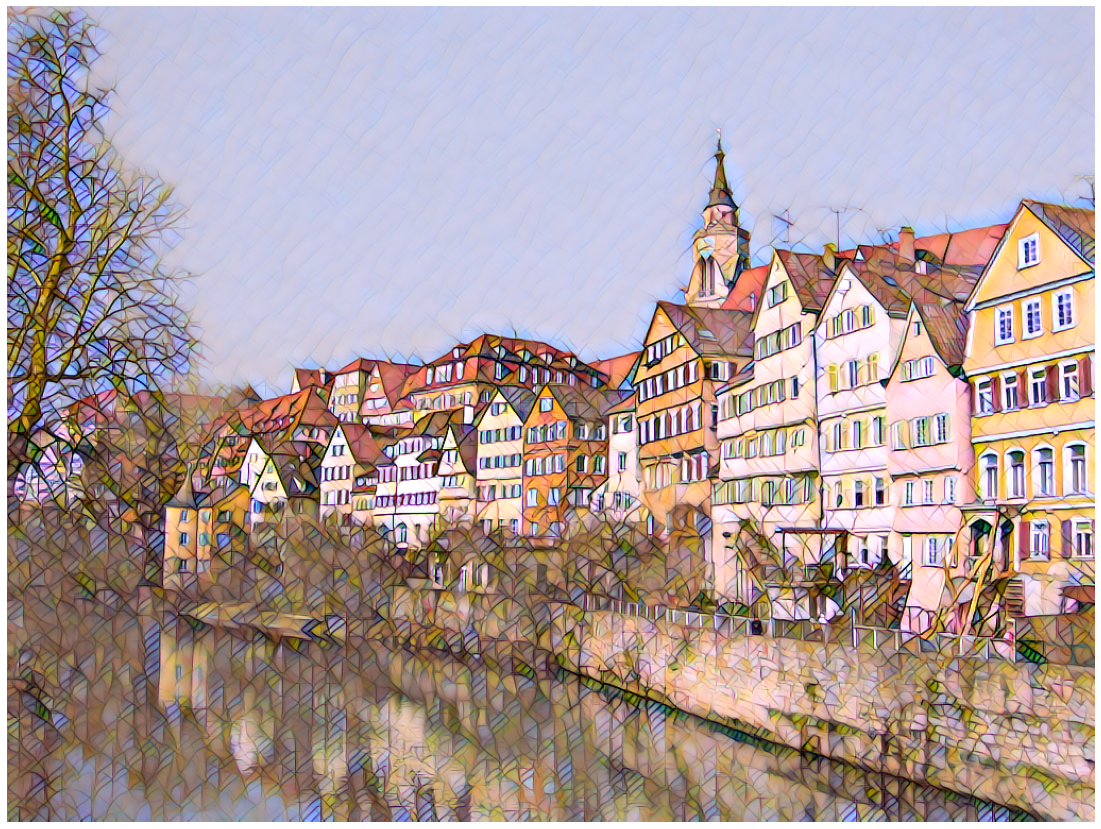

In [37]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

#############
# CODE HERE #
#############
content_img_name = '../dataset/lab10/content/Tuebingen_Neckarfront.jpg'

content_img = Image.open(content_img_name)

content = test_transform(content_img).cuda().unsqueeze(0)

output = transformer(content) # 현재 transformer은 GPU에 올라간 model이다.

output = output.cpu()

print(output.shape)
print(output.dtype)
print(output.type)
# plt.imshow(output[0])

content = inverse_transform(output.squeeze())


plt.figure(figsize=(30, 15))
plt.imshow(content)
plt.axis('off')

위의 그림을 보면 content 정보에 style 정보가 삽입되어 content는 같지만 다른 느낌의 이미지를 얻었다.
여기서 parameter을 조절해서 더 좋은 결과를 얻어라고 했는데 본래는 relu3-3에서 뽑도록 그림이 그려져 있지만
relu 2_2에서 그림을 뽑아서 더 좋은 결과를 얻을 수 있었다. 그 밖에도 content , style, tv loss의 weight를 달리해주는 것이
hyper parameter을 조절하는 것이다.

이 논문에서는 feed-forward image transformation과 perceptual loss function의 high-level feature로 학습하는 system을 만든 결과 기존 의 style transfer과 비슷하게 좋은 결과를 얻었고 속도는 더 빨랐다. 앞서 논문  Image Style Transfer Using Convolutional Neural Networks 은 forward, backward을 함께 진행하면서 input 이미지를 업데이트하기 때문에 매우 느리다. 그러나 이 논문에서 밝힌 방법을 사용하면 위와 같이 좋은 결과를 얻을 수 있을 뿐더러 속도도 더 빨랐다.

예상했던 점 : 논문을 분석하면서 중요한 점이 loss function의 설계였다. 두개의 논문 모두 loss functionn을 잘 설계하는 것으로 이미지의 style과 content을 합성할 수 있었기 때문이다. 두개의 논문 공통점으로는 CNN에서 통과시킨 feature의 channel 간의 연관성 correlation을 구한 Gram matrix을 이용해서 style에 대한 정보를 정의하였다. 그러므로 style을 정보를 학습하고 그 결과 content와 style이 합쳐진 사진을 얻을 수 있을 것이다. 

예상과 달랐던 점 및 개선할 점 : 
논문을 분석할 때 몇가지 의문점이 있었는데 image transform net과 loss network를 어떻게 코드적으로 사용할지가 감이 잡히지 않았다. 이로 인해서 또한 loss function 역시 논문만 읽었을때는 무엇과 무엇을 비교하는지 확실하지 않았다. 그러나 직접 코드를 짜보고 논문을 다시 읽은 결과 두번째 논문에서는 특히 style 정보가 저장된 이미지를 vgg와 통과한 값과 input 이미지를 image transform network에 통과시킨 y_hat을 다시 VGG넷에 통과 시켜 비교하였고 , content 정보 역시 content 정보가 저장된 이미지를 바로 vgg로 통과하고 역시 y_hat을 vgg 통과한 값과 비교해준다는 것을 확실히 배울 수 있었다.
이 연구의 개선점으로 한 network당 하나의 sytle만 학습할 수 있어서 여러 style을 선택하는 multi성이 부족하다. 그래서 이런것을 개선하면 좋을 것이다.

결론 : 결론적으로 style transfer module 중에서 CNN을 이용한 model을 구현하여 image가 어떻게 변하는지 살펴볼 수 있었다.

의문점 : 비록 한 network에 한 style만 저장되는 단점이 있지만 이미 real-time에 성능도 좋은데 최신의 style transfer의 논문은 무엇을 발달시켰을지 궁금하다

### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)